# Panan Salinity Quick Analysis

In [1]:
import intake

import matplotlib.pyplot as plt
import xarray as xr
import cf_xarray as cfxr
import numpy as np

import cmocean as cm
import cartopy.crs as ccrs

import cartopy.feature as cft
import matplotlib.path as mpath

In [2]:
#Importing data
pancontrol01 = intake.open_esm_datastore('/home/272/kc5856/panantrial/experiment_datastore.json', columns_with_iterables=['variable'])
pantrial01 = intake.open_esm_datastore('/home/272/kc5856/catalog_dir/experiment_datastore.json', columns_with_iterables=['variable'])
pancontrol005 = intake.open_esm_datastore('/home/272/kc5856/catalog_dir/panant_005_zstar_access_yr2.json', columns_with_iterables=['variable'])
pantrial005 = intake.open_esm_datastore('/home/272/kc5856/panantrial/panant_005_zstar_MWonly.json', columns_with_iterables=['variable'])

In [3]:
#Starting a dask client
from os import environ
environ["PYTHONWARNINGS"] = "ignore"

from dask.distributed import Client
client = Client(threads_per_worker=1)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46801 instead
  warnings.warn(


### Defining variables

In [4]:
#Time variant variables #ASK HOW TO CONDENSE
control01_salt = pancontrol01.search(variable="so", frequency="1mon").to_dask()#add chunks line in to.dask()
trial01_salt = pantrial01.search(variable="so", frequency="1mon").to_dask()
control005_salt = pancontrol005.search(variable="so",frequency="1mon",file_id=["XXXXXXXX_ocean_month_z"]).to_dask()
trial005_salt = pantrial005.search(variable="so", frequency="1mon").to_dask()

In [15]:
#Salinity at bottom
control01_sob = pancontrol01.search(variable="sob", frequency="1mon").to_dask()#add chunks line in to.dask()
trial01_sob = pantrial01.search(variable="sob", frequency="1mon").to_dask()
control005_sob = pancontrol005.search(variable="sob",frequency="1mon").to_dask()
trial005_sob = pantrial005.search(variable="sob", frequency="1mon").to_dask()

In [16]:
#Time in variant variables
data01_fixed = pancontrol01.search(variable=["areacello","deptho"],path=".*output021.*").to_dask()
data005_fixed = pancontrol005.search(variable=["areacello","deptho"],path=".*output021.*").to_dask()
vol01 = pancontrol01.search(variable=["volcello"],path=".*output021.*",file_id=["XXXXXXXX_ocean_month_z"]).to_dask()
vol005 = pancontrol005.search(variable=["volcello"],path=".*output021.*",file_id=["XXXXXXXX_ocean_month_z"]).to_dask()

In [17]:
#Area weighting
areacello01 = data01_fixed.areacello
areacello005 = data005_fixed.areacello
vol01 = vol01
vol005 = vol005
thick01 = vol01 / areacello01
thick005 = vol005 / areacello005
thick01 = thick01.load()
thick005 = thick005.load()

### Defining shelf mask

In [18]:
def shelf_mask_isobath(var, model_dict):

    paths = {
             "mom5": "/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz",
             "mom6": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc",
            "mom6_005": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_005deg.nc"
             }

    var = var.cf.sel({'latitude': slice(-90, -59)})

    if paths[model_dict][-3:] == '.nc':
        shelf_mask = xr.open_dataset(paths[model_dict])['contour_masked_above']
    else:
        contour_file = np.load(paths[model_dict])
        shelf_mask = xr.DataArray(contour_file['contour_masked_above'],
                                  coords = var.coords, 
                                  dims = var.dims,
                                  name = 'contour_masked_above')
    
    shelf_mask = xr.where(shelf_mask == 0, 1, 0)
    masked_var = var * shelf_mask
    
    return masked_var, shelf_mask

### Panan01

In [19]:
depth = data01_fixed.deptho
land_mask = (depth*0).fillna(1)
depth_shelf, shelf_mask = shelf_mask_isobath(depth, 'mom6')

Loading the salinity time series

In [9]:
cont01_200_time = control01_salt.so.sel(time=slice('2001-01','2010-01')).sel(z_l=slice(0,220)).weighted(thick01['z_l'].fillna(0)).mean(dim='z_l').where(shelf_mask == 1).weighted(areacello01.fillna(0)).mean(dim=('xh','yh'))
pert01_200_time = trial01_salt.so.sel(time=slice('2001-01','2010-01')).sel(z_l=slice(0,220)).weighted(thick01['z_l'].fillna(0)).mean(dim='z_l').where(shelf_mask == 1).weighted(areacello01.fillna(0)).mean(dim=('xh','yh'))

In [10]:
cont01_200_time = cont01_200_time.load()
pert01_200_time = pert01_200_time.load()

Loading the salinity maps

In [12]:
cont01_200_map = control01_salt.so.sel(time=slice('2009-01-01','2010-12-31')).sel(z_l=slice(0,220)).weighted(thick01['z_l'].fillna(0)).mean(dim='z_l').sel(yh=slice(None,-59)).mean(dim='time')
pert01_200_map = trial01_salt.so.sel(time=slice('2009-01-01','2010-12-31')).sel(z_l=slice(0,220)).weighted(thick01['z_l'].fillna(0)).mean(dim='z_l').sel(yh=slice(None,-59)).mean(dim='time')

In [13]:
cont01_200_map.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/pan01_saltC_200map.nc')
pert01_200_map.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/pan01_saltMW_200map.nc')

In [26]:
con01_map = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/pan01_saltC_200map.nc', chunks = {'isopycnal_bins': 1})
melt01_map = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/pan01_saltMW_200map.nc', chunks = {'isopycnal_bins': 1})

In [27]:
anom01_200_map = melt01_map - con01_map
anom01_200_map = anom01_200_map.load()

Plotting

Text(0.5, 1.0, 'Panan01 Time Series of salinity for shelf top 200m')

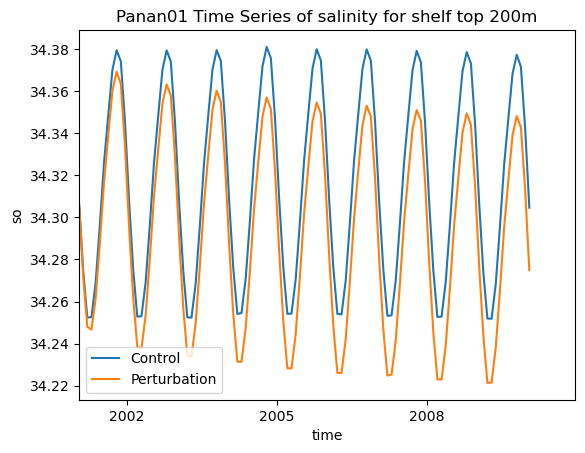

In [17]:
cont01_200_time.plot(label="Control")
pert01_200_time.plot(label="Perturbation")
plt.xlim(380,4000)
plt.legend(loc="lower left")
plt.title("Panan01 Time Series of salinity for shelf top 200m")

In [20]:
land_50m = cft.NaturalEarthFeature("physical", "land", "50m", edgecolor="black", facecolor="papayawhip", linewidth=0.5)
projection = ccrs.SouthPolarStereo()

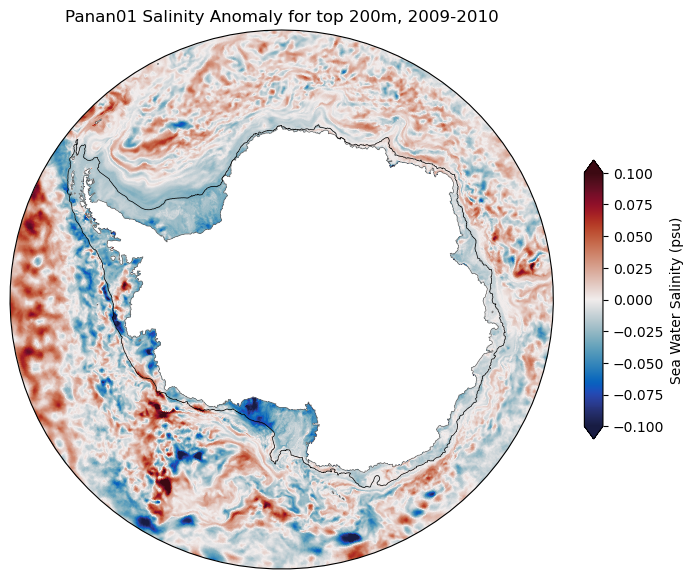

In [28]:
plt.figure(figsize=(8, 7))
ax = plt.axes(projection=projection)

ax.set_extent([-280, 80, -80, -59], crs=ccrs.PlateCarree())

# Compute a circle in axes coordinates, which we can use as a boundary for the map. 
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

ax.contour(land_mask.cf['X'], land_mask.cf['Y'], land_mask,
           levels = [0, 1], colors = 'dimgrey',linewidths=0.5, transform = ccrs.PlateCarree())
ax.contour(shelf_mask.cf['X'], shelf_mask.cf['Y'], shelf_mask,
           levels = [0, 1], colors = 'k', linewidths=0.5,transform = ccrs.PlateCarree())

anom01_200_map.plot(
    x="xh",
    y="yh",
    transform=ccrs.PlateCarree(),
    vmin=-0.1,
    vmax=0.1,
    extend="both",
    cmap=cm.cm.balance, #cm ocean colour maps for more options, matplotlib has more also.
    cbar_kwargs={"label": "Sea Water Salinity (psu)", "fraction": 0.03, "aspect": 15, "shrink": 0.7},
);

plt.title("Panan01 Salinity Anomaly for top 200m, 2009-2010");

#### Bottom salinity

In [21]:
cont01_bot_map = control01_sob.sob.sel(time=slice('2001-01-01','2010-12-31')).sel(yh=slice(None,-59)).mean(dim='time')
pert01_bot_map = trial01_sob.sob.sel(time=slice('2001-01-01','2010-12-31')).sel(yh=slice(None,-59)).mean(dim='time')

In [22]:
cont01_bot_map = cont01_bot_map.load()
pert01_bot_map = pert01_bot_map.load()

In [23]:
anom01_bot_map = pert01_bot_map - cont01_bot_map
anom01_bot_map = anom01_bot_map.load()

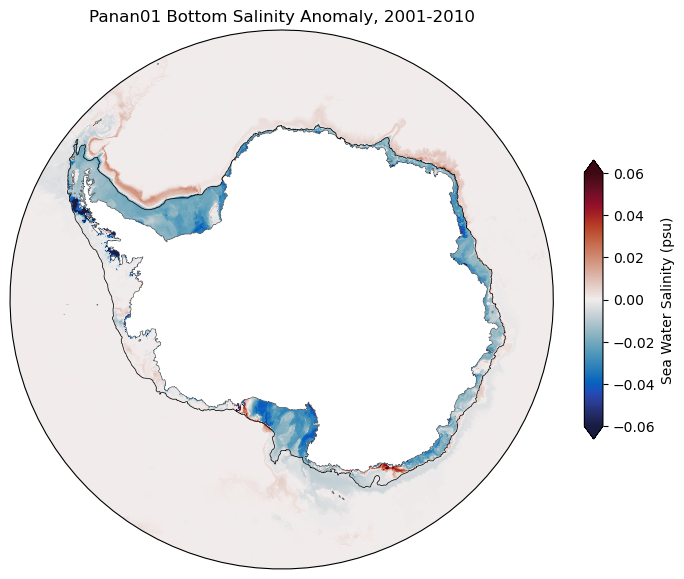

In [26]:
plt.figure(figsize=(8, 7))
ax = plt.axes(projection=projection)

ax.set_extent([-280, 80, -80, -59], crs=ccrs.PlateCarree())

# Compute a circle in axes coordinates, which we can use as a boundary for the map. 
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

ax.contour(land_mask.cf['X'], land_mask.cf['Y'], land_mask,
           levels = [0, 1], colors = 'dimgrey',linewidths=0.5, transform = ccrs.PlateCarree())
ax.contour(shelf_mask.cf['X'], shelf_mask.cf['Y'], shelf_mask,
           levels = [0, 1], colors = 'k', linewidths=0.5,transform = ccrs.PlateCarree())

anom01_bot_map.plot(
    x="xh",
    y="yh",
    transform=ccrs.PlateCarree(),
    vmin=-0.06,
    vmax=0.06,
    extend="both",
    cmap=cm.cm.balance, #cm ocean colour maps for more options, matplotlib has more also.
    cbar_kwargs={"label": "Sea Water Salinity (psu)", "fraction": 0.03, "aspect": 15, "shrink": 0.7},
);

plt.title("Panan01 Bottom Salinity Anomaly, 2001-2010");

### Panan005

In [27]:
depth = data005_fixed.deptho
land_mask = (depth*0).fillna(1)
depth_shelf, shelf_mask = shelf_mask_isobath(depth, 'mom6_005')

Loading time series

In [9]:
# DONE #cont005_200_time = control005_salt.so.sel(time=slice('2001-01','2010-01')).sel(z_l=slice(0,220)).weighted(thick005['z_l'].fillna(0)).mean(dim='z_l').where(shelf_mask == 1).weighted(areacello005.fillna(0)).mean(dim=('xh','yh'))
pert005_200_time = trial005_salt.so.sel(time=slice('2001-01','2010-01')).sel(z_l=slice(0,220)).weighted(thick005['z_l'].fillna(0)).mean(dim='z_l').where(shelf_mask == 1).weighted(areacello005.fillna(0)).mean(dim=('xh','yh'))

In [10]:
# DONE #cont005_200_time.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/pan005_saltC_200time.nc')
pert005_200_time.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/pan005_saltMW_200time.nc')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 81.82 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [11]:
con005_200time = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/pan005_saltC_200time.nc', chunks = {'isopycnal_bins': 1})
melt005_200time = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/pan005_saltMW_200time.nc', chunks = {'isopycnal_bins': 1})

Loading maps

In [16]:
cont005_200_map = control005_salt.so.sel(time=slice('2009-01-01','2010-12-31')).sel(z_l=slice(0,220)).weighted(thick005['z_l'].fillna(0)).mean(dim='z_l').sel(yh=slice(None,-59)).mean(dim='time')
pert005_200_map = trial005_salt.so.sel(time=slice('2009-01-01','2010-12-31')).sel(z_l=slice(0,220)).weighted(thick005['z_l'].fillna(0)).mean(dim='z_l').sel(yh=slice(None,-59)).mean(dim='time')

In [17]:
cont005_200_map.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/pan005_saltC_200map.nc')
pert005_200_map.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/pan005_saltMW_200map.nc')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 11.77 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 11.76 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [19]:
con005_200_map = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/pan005_saltC_200map.nc', chunks = {'isopycnal_bins': 1})
melt005_200_map = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/pan005_saltMW_200map.nc', chunks = {'isopycnal_bins': 1})

In [22]:
anom005_200_map = melt005_200_map - con005_200_map
anom005_200_map = anom005_200_map.load()

Plotting

Text(0.5, 1.0, 'Panan005 Time Series of salinity for shelf top 200m')

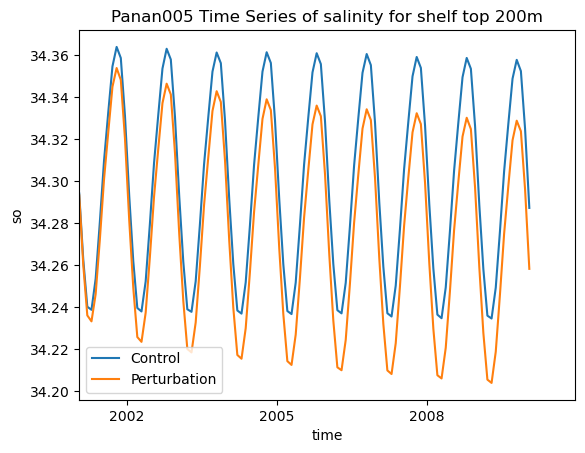

In [13]:
con005_200time.plot(label="Control")
melt005_200time.plot(label="Perturbation")
plt.xlim(380,4000)
plt.legend(loc="lower left")
plt.title("Panan005 Time Series of salinity for shelf top 200m")

In [20]:
land_50m = cft.NaturalEarthFeature("physical", "land", "50m", edgecolor="black", facecolor="papayawhip", linewidth=0.5)
projection = ccrs.SouthPolarStereo()

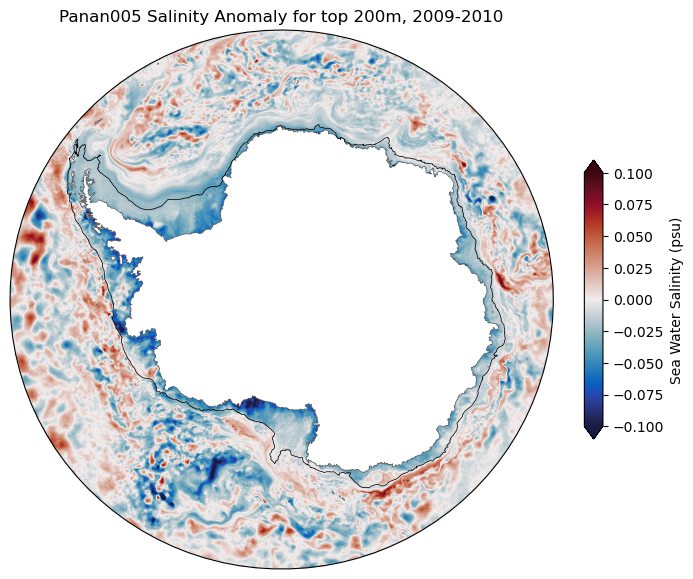

In [24]:
plt.figure(figsize=(8, 7))
ax = plt.axes(projection=projection)

ax.set_extent([-280, 80, -80, -59], crs=ccrs.PlateCarree())

# Compute a circle in axes coordinates, which we can use as a boundary for the map. 
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

ax.contour(land_mask.cf['X'], land_mask.cf['Y'], land_mask,
           levels = [0, 1], colors = 'dimgrey',linewidths=0.5, transform = ccrs.PlateCarree())
ax.contour(shelf_mask.cf['X'], shelf_mask.cf['Y'], shelf_mask,
           levels = [0, 1], colors = 'k', linewidths=0.5,transform = ccrs.PlateCarree())

anom005_200_map.plot(
    x="xh",
    y="yh",
    transform=ccrs.PlateCarree(),
    vmin=-0.1,
    vmax=0.1,
    extend="both",
    cmap=cm.cm.balance, #cm ocean colour maps for more options, matplotlib has more also.
    cbar_kwargs={"label": "Sea Water Salinity (psu)", "fraction": 0.03, "aspect": 15, "shrink": 0.7},
);

plt.title("Panan005 Salinity Anomaly for top 200m, 2009-2010");

#### Bottom salinity

In [28]:
cont005_bot_map = control005_sob.sob.sel(time=slice('2001-01-01','2010-12-31')).sel(yh=slice(None,-59)).mean(dim='time')
pert005_bot_map = trial005_sob.sob.sel(time=slice('2001-01-01','2010-12-31')).sel(yh=slice(None,-59)).mean(dim='time')

In [29]:
cont005_bot_map = cont005_bot_map.load()
pert005_bot_map = pert005_bot_map.load()

In [30]:
anom005_bot_map = pert005_bot_map - cont005_bot_map
anom005_bot_map = anom005_bot_map.load()

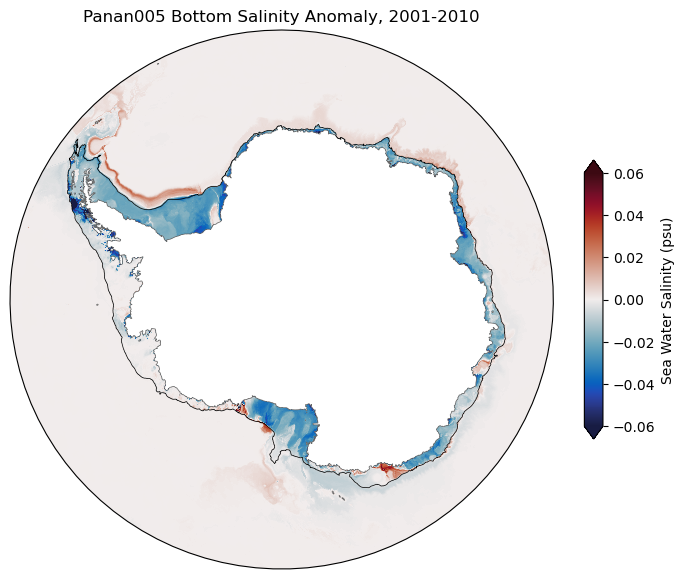

In [31]:
plt.figure(figsize=(8, 7))
ax = plt.axes(projection=projection)

ax.set_extent([-280, 80, -80, -59], crs=ccrs.PlateCarree())

# Compute a circle in axes coordinates, which we can use as a boundary for the map. 
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

ax.contour(land_mask.cf['X'], land_mask.cf['Y'], land_mask,
           levels = [0, 1], colors = 'dimgrey',linewidths=0.5, transform = ccrs.PlateCarree())
ax.contour(shelf_mask.cf['X'], shelf_mask.cf['Y'], shelf_mask,
           levels = [0, 1], colors = 'k', linewidths=0.5,transform = ccrs.PlateCarree())

anom005_bot_map.plot(
    x="xh",
    y="yh",
    transform=ccrs.PlateCarree(),
    vmin=-0.06,
    vmax=0.06,
    extend="both",
    cmap=cm.cm.balance, #cm ocean colour maps for more options, matplotlib has more also.
    cbar_kwargs={"label": "Sea Water Salinity (psu)", "fraction": 0.03, "aspect": 15, "shrink": 0.7},
);

plt.title("Panan005 Bottom Salinity Anomaly, 2001-2010");